In [1]:
import ee
import datetime
import os
import itertools
import sys

from pprint import pprint
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import geemap

import subprocess
from subprocess import PIPE

In [2]:
ee.Initialize()

In [3]:
# define basic parameters
year_range = [f'{i}_{i+2}' for i in range(1990,2020,3)]

In [4]:
year_range

['1990_1992',
 '1993_1995',
 '1996_1998',
 '1999_2001',
 '2002_2004',
 '2005_2007',
 '2008_2010',
 '2011_2013',
 '2014_2016',
 '2017_2019']

In [5]:
# import boundry 
North_China_Plain = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Boundary")
North_China_Plain_city = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_city_boundary")
North_China_Plain_province = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_province_boundry")
North_China_Plain_County = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_County")
North_China_Plain_Towm = ee.FeatureCollection("users/wangjinzhulala/North_China_Plain_Python/Boundary_shp/North_China_Plain_Town")

In [19]:
# define the zoning boundy for area calculation
Zoning_shp = North_China_Plain_province

### calculate the area change of the classification

##### Import my result, GAIA and GIP_2015 

In [20]:
# get the classification of this study
My_img = ee.Image("users/wangjinzhulala/North_China_Plain_Python/classificatioin_temporal_checked/Mosaic_only_forward")

# get the GAIA classification product
GAIA_img = ee.Image("users/wangjinzhulala/North_China_Plain_Python/Reference_classification/GAIA_NCP")

# get the Global Impervious Surface of 2015
GIP_2015 = ee.Image("users/wangjinzhulala/North_China_Plain_Python/Reference_classification/Global_Impervious_Surface_2015_NCP")\
             .remap([1,2],[0,1]).rename('b1')

##### Preprocessing for classifications, which is to make it seperate imgs rather than one mosaic img 

In [21]:
# construc year:value dict to dilineate the value from mosaiced classifications

# get the value dict of my result 
My_value = dict(zip(year_range,range(10,0,-1)))

# get the GAIA value dict
GAIA_value = dict(zip(range(1985,2019),range(34,0,-1)))

# add {2019:1} to the dictionary, because GAIA does not 
# extend to 2019, we just use its latest pixel of 2018
GAIA_value.update({2019:1})

##### Calculate the area changes

In [22]:
# initiate an empty list to hold the result
Stats_df_list = []

for year in year_range:
    
    year_GAIA = int(year[-4:])
    
    # get the classificaiton
    img_my   = ee.Image(My_img.gte(My_value[year]))
    img_GAIA = ee.Image(GAIA_img.gte(GAIA_value[year_GAIA]))
             
    # get the pixel count 
    Stats_my   = img_my.reduceRegions(reducer     = ee.Reducer.sum(), 
                                      collection  = Zoning_shp, 
                                      scale       = 30,
                                      tileScale   = 1).select(['EN_Name','sum']).getInfo()
                        
    Stats_GAIA = img_GAIA.reduceRegions(reducer     = ee.Reducer.sum(), 
                                        collection  = Zoning_shp, 
                                        scale       = 30,
                                        tileScale   = 1).select(['EN_Name','sum']).getInfo()
    
    # store the pixel count into a df 
    sum_my = pd.DataFrame([i['properties'] for i in Stats_my['features']])
    sum_my['year'] = year
    sum_my['Type'] = 'My'
                        
    sum_GAIA = pd.DataFrame([i['properties'] for i in Stats_GAIA['features']])
    sum_GAIA['year'] = year
    sum_GAIA['Type'] = 'GAIA'
    
    # append the area_sum to df_list
    sum_df = pd.concat([sum_my,sum_GAIA])
    Stats_df_list.append(sum_df)

    # print out the process
    print(f'Area calculation of {year} finished!')

Area calculation of 1990_1992 finished!
Area calculation of 1993_1995 finished!
Area calculation of 1996_1998 finished!
Area calculation of 1999_2001 finished!
Area calculation of 2002_2004 finished!
Area calculation of 2005_2007 finished!
Area calculation of 2008_2010 finished!
Area calculation of 2011_2013 finished!
Area calculation of 2014_2016 finished!
Area calculation of 2017_2019 finished!


##### Save area change to disk

In [23]:
# store the area change to a df
Area_stack = pd.concat(Stats_df_list)

# save to dis
Area_stack.to_csv('./Result/Area_change.csv',index=False)

# read csv
Area_stack = pd.read_csv('./Result/Area_change.csv')

#### Observe that there is a noticibel dirrerence in total area between my result and the GAIA

In [24]:
Area_stack

,EN_Name,sum,year,Type
0,Shandong,1.163410e+07,1990_1992,My
1,Henan,9.259521e+06,1990_1992,My
2,Beijing,9.284888e+05,1990_1992,My
3,Tianjin,8.087451e+05,1990_1992,My
4,Hebei,7.989920e+06,1990_1992,My
...,...,...,...,...
135,Beijing,5.197076e+06,2017_2019,GAIA
136,Tianjin,4.120395e+06,2017_2019,GAIA
137,Hebei,2.641546e+07,2017_2019,GAIA
138,Anhui,1.427950e+07,2017_2019,GAIA


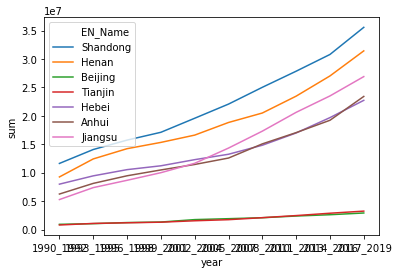

In [30]:
sns.lineplot(data=Area_stack[Area_stack['Type']=='My'],
             x='year',
             y='sum',
            hue = 'EN_Name')

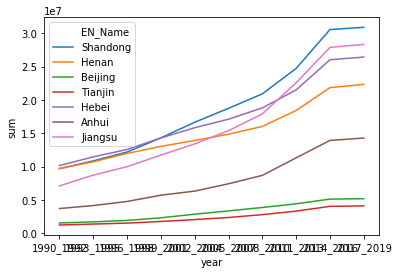

In [31]:
sns.lineplot(data=Area_stack[Area_stack['Type']=='GAIA'],
             x='year',
             y='sum',
            hue = 'EN_Name')

In [27]:
Area_sum = Area_stack.groupby(['year','Type']).sum().reset_index()

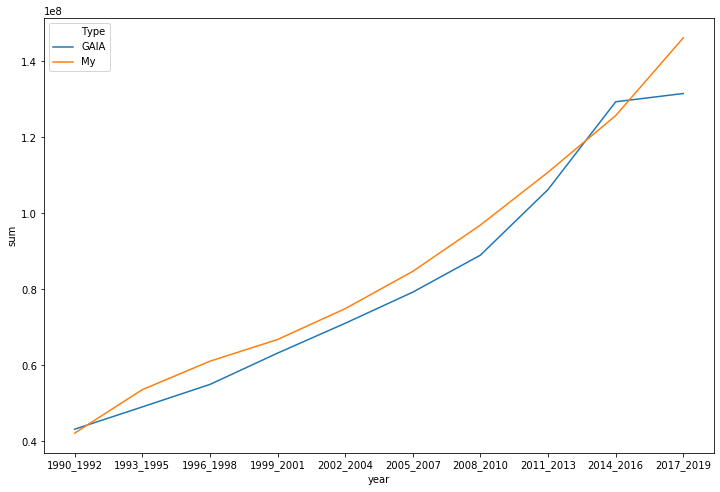

In [28]:
plt.figure(figsize=(12,8))

sns.lineplot(data=Area_sum,
             x='year',
             y='sum',
            hue = 'Type')